In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Data/aapl_5m_train.csv')
df.drop(columns=['Unnamed: 0', 'Datetime', 'Gmtoffset', 'Volume'], inplace=True)
df['diff'] = df['Close'].diff()
df = df.dropna().reset_index(drop=True)

# Block Method

In [4]:
windows = [5, 10, 20, 50, 100]

for window in windows:
     covs = [None] * len(df)

     for i in range(len(df) - 2 * window + 1):
          up = df['diff'][i:i + window]
          down = df['diff'][i + window:i + 2 * window]

          cov = np.cov(up, down)[0][1]
          covs[i + 2 * window - 1] = cov
     
     df[f'cov_{window}'] = covs
     df[f'Spread_{window}'] = 2 * np.sqrt(np.abs(df[f'cov_{window}']))

bid_ask = pd.DataFrame()

for window in windows:
    bid_ask[f'Bid_{window}'] = np.where(
        df['diff'] > 0,
        df['Close'] - df[f'Spread_{window}'],
        df['Close']
    )

    bid_ask[f'Ask_{window}'] = np.where(
        df['diff'] <= 0,
        df['Close'] + df[f'Spread_{window}'],
        df['Close']
    )

bid_ask


,Bid_5,Ask_5,Bid_10,Ask_10,Bid_20,Ask_20,Bid_50,Ask_50,Bid_100,Ask_100
0,131.889999,NaN,131.889999,NaN,131.889999,NaN,131.889999,NaN,131.889999,NaN
1,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997,NaN,132.059997
2,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000,NaN,132.250000
3,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN,131.589996,NaN
4,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN,131.448898,NaN
...,...,...,...,...,...,...,...,...,...,...
39567,128.911003,129.054992,128.990683,129.054992,128.968943,129.054992,129.008188,129.054992,128.854473,129.054992
39568,129.174315,129.380004,129.351767,129.380004,129.309047,129.380004,129.332813,129.380004,129.179958,129.380004
39569,129.588059,129.764404,129.571969,129.764404,129.655864,129.764404,129.727883,129.764404,129.561978,129.764404
39570,129.773803,129.949996,129.767916,129.949996,129.871503,129.949996,129.895281,129.949996,129.746514,129.949996


Text(0, 0.5, 'Average Spread')

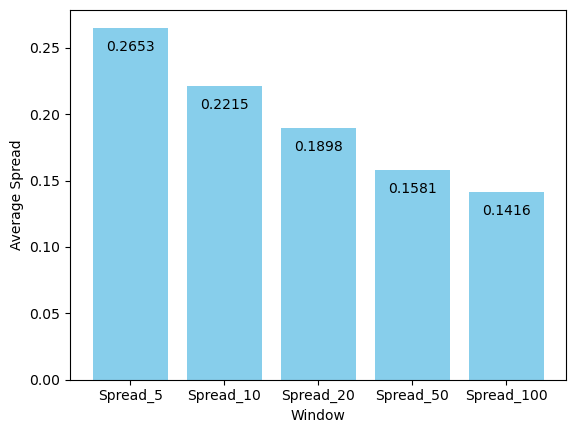

In [5]:
spread_cols = [c for c in df.columns if 'Spread' in c]
spread_means = [df[col].mean() for col in spread_cols]

plt.figure()
plt.bar(spread_cols, spread_means, color='skyblue')
for i, v in enumerate(spread_means):
    plt.text(i, v - 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.xlabel('Window')
plt.ylabel('Average Spread')

# Serial Covariance

In [6]:
df2 = df.copy()
df2['diff1'] = df2['diff'].shift(1)
df2 = df2.dropna().reset_index(drop=True)

for window in windows:
    df2[f'Cov_{window}'] = df2['diff'].rolling(window=window).cov(df2['diff1'])
    df2[f'Spread_{window}'] = 2 * np.sqrt(np.abs(df2[f'Cov_{window}'])) 

bid_ask = pd.DataFrame()

for window in windows:
    bid_ask[f'Bid_{window}'] = np.where(
        df2['diff'] > 0,
        df2['Close'] - df2[f'Spread_{window}'],
        df2['Close']
    )

    bid_ask[f'Ask_{window}'] = np.where(
        df2['diff'] <= 0,
        df2['Close'] + df2[f'Spread_{window}'],
        df2['Close']
    )

bid_ask

,Bid_5,Ask_5,Bid_10,Ask_10,Bid_20,Ask_20,Bid_50,Ask_50,Bid_100,Ask_100
0,NaN,130.140792,NaN,130.140792,NaN,130.140792,NaN,130.140792,NaN,130.140792
1,129.804901,NaN,129.804901,NaN,129.804901,NaN,129.804901,NaN,129.804901,NaN
2,129.369995,NaN,129.369995,NaN,129.369995,NaN,129.369995,NaN,129.369995,NaN
3,129.240005,NaN,129.240005,NaN,129.240005,NaN,129.240005,NaN,129.240005,NaN
4,129.100006,129.259162,129.100006,NaN,129.100006,NaN,129.100006,NaN,129.100006,NaN
...,...,...,...,...,...,...,...,...,...,...
39368,128.962185,129.054992,128.884329,129.054992,128.965072,129.054992,128.975079,129.054992,128.922074,129.054992
39369,129.270764,129.380004,129.195466,129.380004,129.259212,129.380004,129.291819,129.380004,129.246591,129.380004
39370,129.532411,129.764404,129.690239,129.764404,129.712092,129.764404,129.712193,129.764404,129.612325,129.764404
39371,129.738496,129.949996,129.806255,129.949996,129.858353,129.949996,129.860760,129.949996,129.788603,129.949996


Text(0, 0.5, 'Average Spread')

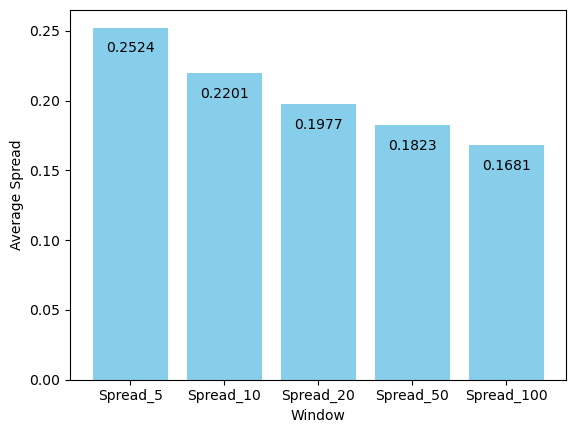

In [7]:
spread_cols = [c for c in df.columns if 'Spread' in c]
spread_means = [df2[col].mean() for col in spread_cols]

plt.figure()
plt.bar(spread_cols, spread_means, color='skyblue')
for i, v in enumerate(spread_means):
    plt.text(i, v - 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.xlabel('Window')
plt.ylabel('Average Spread')

# Conclusiones

Despúes de realizar los dos métodos para calcular los spreads de dicho dataset, podemos ver que utilizando ambos métodos entre más grande sea el tamaño de muestra, en este caso las ventanas, los spreads promedio se van haciendo más pequeños, se podría decir que entre más datos se utilicen para calcular los spreads utilizando estos métodos mas preciso será su calculo, en cuanto a que método es mejor, en este caso sería el de Serial Covariance ya que lo que hace este método es ir calculando los datos uno a uno, es decir el actual con el anterior y luego el siguiente dato con el anterior y así progresivamente, a diferencia del Block Method donde se va haciendo el calculo agrupando cierta cantidad de datos, lo cual puede llegar a suavizar las variaciones rapidas, haciendo el calculo no tan preciso.

En cuanto a las ventanas utilizadas, la óptima podría ser la de 20 ya que tiene un gran balance, en el sentido en el que no es tan pequeña como para que exista mucho ruido pero tampoco tan grande como para suavizar tanto el resultado y borrar eventos importantes.